In [ ]:
import sys
sys.path.append("../src")

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw
import numpy as np
import time
import shutil
from pathlib import Path

from deepinterpolation_recording import DeepInterpolatedRecording


%matplotlib widget

In [ ]:
#sw.set_default_plotter_backend("ipywidgets")

In [ ]:
rec_file = "/home/buccino/data/Neuropixels2.0_Recording/open-ephys-np2/595262_2022-02-22_16-47-26/"

In [ ]:
rec = se.read_openephys(rec_file)

In [ ]:
rec

In [ ]:
rec.get_dtype()

FILTERING AND ZSCORING

In [ ]:
model = "../trained_models/test_training_no_hp_filter_t20s_v0.5s/first_test_unet_single_ephys_1024_mean_absolute_error_model.h5"

In [ ]:
recording_filtered = spre.bandpass_filter(rec)
#rec=si.load_extractor("recording_rescaled_di_bp/")

In [ ]:
from spikeinterface.core import get_random_data_chunks
random_data = get_random_data_chunks(recording_filtered)
means = np.mean(random_data, axis=0)
means = means[None, :]
stds = np.std(random_data, axis=0)
stds = stds[None, :] 
gain = stds # gain should be the stds
#gain_hp_filter= gain
offset = -means / stds
#offset_hp_filter= offset

In [ ]:
print(gain)

In [ ]:
recording_filtered_z = spre.zscore(recording_filtered)

In [ ]:
test_start_s = 0
test_end_s = 10
fs = rec.sampling_frequency

start_frame = int(test_start_s* fs)
end_frame = int(test_end_s* fs)

### Test GPU

In [ ]:
use_gpu = True

In [ ]:
rec_di_gpu = DeepInterpolatedRecording(recording_filtered_z, model, use_gpu=True, memory_gpu=512)
rec_di = rec_di_gpu

In [ ]:
#rec_di = spre.bandpass_filter(rec_di)

In [ ]:
#rec_di_one = recording_di_bp_filter_rescaled.select_segments(0)
#rec_di_slice = rec_di_one.frame_slice(start_frame=start_frame, end_frame=end_frame)

In [ ]:
rec_norm_no_hp = spre.bandpass_filter(rec_di)

In [ ]:
recording_rescaled= spre.scale(rec_norm_no_hp, gain= gain, offset= -offset, dtype='float') #gain should be the stds
#recording_rescaled= spre.scale(rec_di, gain= gain, offset= -offset, dtype='float') #gain should be the stds

In [ ]:
recording_rescaled.get_dtype()

In [ ]:
traces_or = recording_filtered.get_traces(start_frame=3000, end_frame=13005)
traces_or.shape

In [ ]:
traces_processed = recording_rescaled.get_traces(start_frame=3000, end_frame=13005)

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 15))

diff_bp_di = traces_or - traces_processed

ax1.imshow(traces_or[:600].T)
ax2.imshow(traces_processed[:600].T)
ax3.imshow(diff_bp_di[:600].T)

ax1.set_xlabel('Sample index')
ax1.set_ylabel('Electrode channel')
ax1.set_title('Data Before Zscoring')

ax2.set_xlabel('Sample index')
ax2.set_ylabel('Electrode channel')
ax2.set_title('Data After Rescaling by gain and offset')

ax3.set_xlabel('Sample index')
ax3.set_ylabel('Electrode channel')
ax3.set_title('Difference')

#fig.suptitle('Comparison between original and predicted -bandpass then deepinterpolation filtering- segment, for Neuropixels2.0')
#plt.subplots_adjust(top=1)

#plt.savefig('/home/buccino/Visual Results/Spikeinterface/Neuropixels1.0/Visual graph/Comparison between original and predicted -bandpass then deepinterpolation filtering- segment, for Neuropixels2.0 recording.png')

In [ ]:
recording_rescaled= spre.scale(recording_rescaled, gain= 1, offset= 1, dtype='int16')

In [ ]:
chunk_duration = "50ms"
#n_jobs = 4

Caution: make sure to change the name of the section

In [ ]:
output_folder = Path("recording_rescaled_di_bp")
if output_folder.is_dir():
    shutil.rmtree(output_folder)

In [ ]:
chunk_duration = "50ms"
n_jobs = 8

t_start = time.perf_counter()
rec_saved_gpu = recording_rescaled.save(folder=output_folder, n_jobs=n_jobs, progress_bar=True, 
                                  chunk_duration=chunk_duration)
t_stop = time.perf_counter()
elapsed_gpu = t_stop - t_start
print(f"Elapsed GPU with {n_jobs} jobs - chunk {chunk_duration}: {np.round(elapsed_gpu, 2)}")

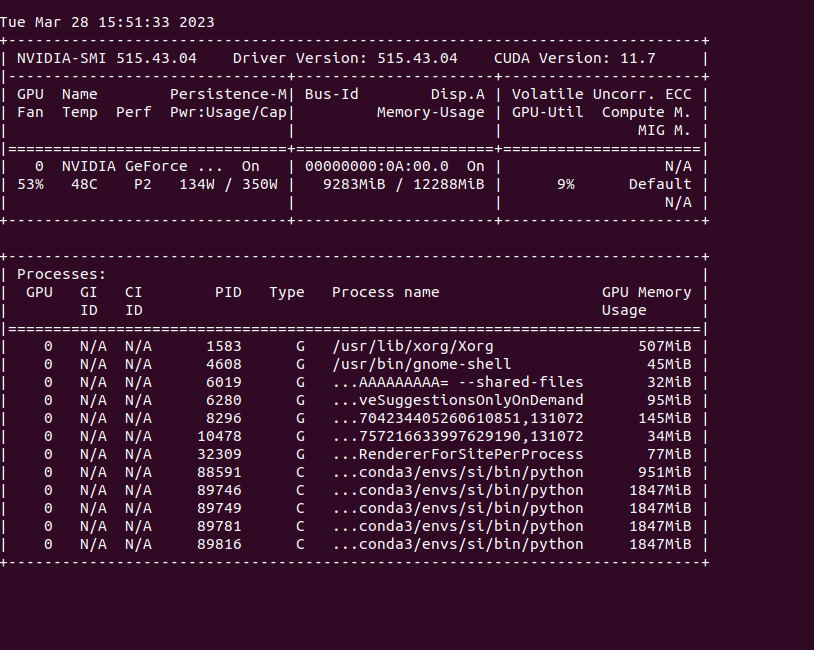

ASSESSING QUALITY OF RESULTS

In [ ]:
rec_test_1=si.load_extractor("recording_rescaled_di_bp/")

In [ ]:
rec_test_1

In [ ]:
from spikeinterface.core import get_random_data_chunks
random_data_test = get_random_data_chunks(rec_test_1)
means_test = np.mean(random_data_test, axis=0)
means_test = means_test[None, :]
stds_test = np.std(random_data_test, axis=0)
stds_test = stds_test[None, :] 
gain_test = stds_test # gain should be the stds
#gain_hp_filter= gain
offset_test = -means_test / stds_test
#offset_hp_filter= offset
print(gain_test)

### Test CPU

In [ ]:
use_gpu = False

In [ ]:
rec_di_cpu = DeepInterpolatedRecording(rec_hp, model_hp_path, use_gpu=use_gpu)
rec_di = rec_di_cpu

In [ ]:
rec_di_one = rec_di.select_segments(0)
rec_di_slice = rec_di_one.frame_slice(start_frame=start_frame, end_frame=end_frame)

In [ ]:
chunk_duration = "50ms"
n_jobs = 12

In [ ]:
output_folder = Path("test_multi_di_cpu")
if output_folder.is_dir():
    shutil.rmtree(output_folder)

In [ ]:
t_start = time.perf_counter()
rec_save = rec_di_slice.save(folder=output_folder, n_jobs=n_jobs, progress_bar=True, 
                             chunk_duration=chunk_duration)
t_stop = time.perf_counter()
elapsed_cpu = t_stop - t_start
print(f"Elapsed CPU with {n_jobs} jobs - chunk {chunk_duration}: {np.round(elapsed_cpu, 2)}")

In [ ]:
sw.plot_timeseries(rec_hp, clim=(-3, 3), segment_index=0)